## 模型介绍

1. 基于**卷积神经网络**的情感分析
2. 输入为**随机**初始化词向量
3. CNN的结构：filter_length = 3,4,5的卷积核各100 个。
4. SST-5数据集

In [1]:
import keras 
from  os.path import join
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Lambda,Input
from keras.layers import Embedding
from keras.layers import Convolution1D
from keras.datasets import imdb
from keras import backend as K
from keras.layers import Convolution1D, GlobalMaxPooling1D,Convolution2D,merge
from keras.utils import np_utils
from keras.models import Model
from keras.regularizers import l2

Using Theano backend.
Using gpu device 0: GeForce GT 630 (CNMeM is disabled, cuDNN not available)


## 数据预处理

In [2]:
file_names = ['stsa.fine.test','stsa.fine.train','stsa.fine.dev']
file_path = '/home/bruce/data/sentiment/'
def read_file(fname=''):
    with open(join(file_path,fname)) as fr:
        lines = fr.readlines()
    lines = [line.strip().lower() for line in lines]
    lables = [int(line[0:1]) for line in lines]
    words = [line[2:].split() for line in lines]
    return words,lables       
train_X,train_y = read_file(fname='stsa.fine.train')
test_X,test_y = read_file(fname='stsa.fine.test')
dev_X,dev_y = read_file(fname='stsa.fine.dev')
print(len(train_X))
print(len(test_X))
print(len(dev_X))
print(train_X[0:2])
print(train_y[0:2])

8544
2210
1101
[['a', 'stirring', ',', 'funny', 'and', 'finally', 'transporting', 're-imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'films'], ['apparently', 'reassembled', 'from', 'the', 'cutting-room', 'floor', 'of', 'any', 'given', 'daytime', 'soap', '.']]
[4, 1]


### 句子长度统计信息

In [3]:
def statics_list2(arrays=[]):
    lengths = [len(i) for i in arrays]
    lengths = sorted(lengths)
    length = len(lengths)
    print('length = ',len(lengths))
    print('max = ',lengths[-1])
    print('min =',lengths[0])
    print('average = ',sum(lengths)/length)
    print('top 50% = ',lengths[int(0.5*length)])
    print('top 80% = ',lengths[int(0.8*length)])
    print('top 90% = ',lengths[int(0.9*length)])
    print('top 95% = ',lengths[int(0.95*length)])
    
statics_list2(arrays=train_X)

length =  8544
max =  52
min = 2
average =  19.143960674157302
top 50% =  18
top 80% =  27
top 90% =  32
top 95% =  35


In [4]:
def token_to_index(datas=[]):
    word_index={}
    count=1
    for data in datas:
        for list_ in data:
            for w in list_:
                if w not in word_index:
                    word_index[w] = count
                    count = count + 1
    print('leng of word_index =',len(word_index))
    for i in range(len(datas)):
        datas[i] = [[ word_index[w] for w in line ] for line in datas[i]] 
    return datas,word_index

In [5]:
X,word_index = token_to_index(datas=[train_X,dev_X])
train_X,dev_X = X
print(len(word_index))

leng of word_index = 17611
17611


## 构建模型

In [29]:
max_len = 52
batch_size=32

max_features = 17612
embedding_dim = 100

nb_filter = 100
dense1_hindden = 300
nb_classes = 5

In [37]:
print('Build model...')
input_random = Input(shape=(max_len,), dtype='int32', name='main_input1')
embedding = Embedding(output_dim=embedding_dim, input_dim=max_features)(input_random)
# 卷积层
conv1 = Convolution1D(nb_filter = nb_filter,
                        filter_length = 2,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding)
conv2 = Convolution1D(nb_filter = nb_filter,
                        filter_length = 3,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding)

conv3 = Convolution1D(nb_filter = nb_filter,
                        filter_length = 4,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding)
conv1 =GlobalMaxPooling1D()(conv1)
conv2 =GlobalMaxPooling1D()(conv2)
conv3 =GlobalMaxPooling1D()(conv3)
merged_vector = merge([conv1,conv2,conv3], mode='concat')
# 全连接层
#dense_layer = Dense(dense1_hindden)
#dens1 = dense_layer(merged_vector)
print('dense_layer input_shape should == (300,)')
#print(dense_layer.input_shape)
#dens1 = Activation('relu')(dens1)

# softmax层
dens2 = Dense(nb_classes)(merged_vector)
output_random = Activation('softmax')(dens2)

model = Model(input=input_random,output=output_random)
print('finish build model')
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Build model...
dense_layer input_shape should == (300,)
finish build model


## 模型图

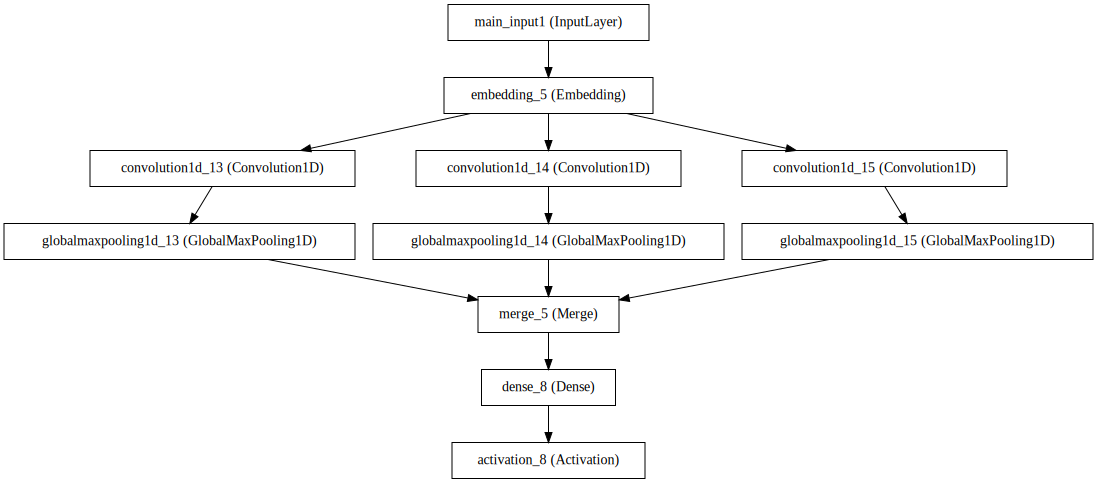

In [38]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 模型输入

In [39]:
print(type(train_y[0]))
train_y_model = np_utils.to_categorical(train_y, nb_classes)
dev_y_model = np_utils.to_categorical(dev_y, nb_classes)
train_X_model = sequence.pad_sequences(train_X, maxlen=max_len)
dev_X_model = sequence.pad_sequences(dev_X, maxlen=max_len)

<class 'int'>


In [40]:
#test 数据
test_index_X= [[word_index[w] if w in word_index else 0 for w in line] for line in test_X]
test_X_model = sequence.pad_sequences(test_index_X,maxlen=max_len)
test_y_model = np_utils.to_categorical(test_y,nb_classes)

In [41]:
print(test_y_model[0:10])

[[ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]]


In [42]:
def my_generator(X=None,y=None):
    i = 0
    max_i = int(len(X)/batch_size)
    while True:
        i = i % max_i
        x_batch = X[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield (x_batch,y_batch)
        i = i + 1
    

In [43]:
model.fit_generator(my_generator(train_X_model,train_y_model),samples_per_epoch = 32*100,nb_epoch=100,verbose=1,validation_data=(test_X_model,test_y_model))

Epoch 1/100
3200/3200 [==============================] - 12s - loss: 1.5772 - acc: 0.2684 - val_loss: 1.5833 - val_acc: 0.2312
Epoch 2/100
3200/3200 [==============================] - 12s - loss: 1.5574 - acc: 0.2881 - val_loss: 1.5716 - val_acc: 0.2462
Epoch 3/100
3200/3200 [==============================] - 12s - loss: 1.5560 - acc: 0.2969 - val_loss: 1.5553 - val_acc: 0.2982
Epoch 4/100
3200/3200 [==============================] - 12s - loss: 1.5340 - acc: 0.3156 - val_loss: 1.5520 - val_acc: 0.2923
Epoch 5/100
3200/3200 [==============================] - 12s - loss: 1.5285 - acc: 0.3225 - val_loss: 1.5315 - val_acc: 0.3186
Epoch 6/100
3200/3200 [==============================] - 12s - loss: 1.5048 - acc: 0.3297 - val_loss: 1.5244 - val_acc: 0.3172
Epoch 7/100
3200/3200 [==============================] - 12s - loss: 1.4893 - acc: 0.3431 - val_loss: 1.5135 - val_acc: 0.3244
Epoch 8/100
3200/3200 [==============================] - 12s - loss: 1.4810 - acc: 0.3569 - val_loss: 1.4956 - 

KeyboardInterrupt: 

## 试验记录

#### 2016年11月12日 10：16  最佳 0.4015




参数

max_len = 36 batch_size=32

max_features = 14714 embedding_dims = 100

nb_filter = 150  filter_length = 2  dense1_hindden = 100  nb_classes = 5

####  2016年11月12日 10：22 最佳成绩 0.4069 


参数

max_len = 36 batch_size=32

max_features = 14714 embedding_dims = 50

nb_filter = 150  filter_length = 2  dense1_hindden = 100  nb_classes = 5

####  2016年11月12日 10：22 最佳成绩  0.4151

参数

max_len = 36 batch_size=32

max_features = 14714 embedding_dims = 150

nb_filter = 150 filter_length = 2 dense1_hindden = 100 nb_classes = 5

#### 2016年11月12日 10：22 最佳成绩  0.4242 [ 0.4214, 0.4033,0.4024 ,0.4151,0.4242]

参数

max_len = 36 batch_size=32

max_features = 14714 embedding_dims = 200

nb_filter = 150 filter_length = 2 dense1_hindden = 100 nb_classes = 5

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

data_dim = 16
timesteps = 8
nb_classes = 10

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(32, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
